In [1]:
import os
import sys
import subprocess
import datetime as dt
import itertools
import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster
import dask.array as da
import matplotlib.pyplot as plt

In [7]:
workdir='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/'
mdirC5='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/data/predictions/cansipsv3_daily/CanESM5'


In [8]:
fnameCanESMAnomDetrByLead=lambda mdir, climyfirst, climylast, ilead, istartlat: f"{mdir}/byLeadDetr/anomDetrByLead_cwao_CanESM5.1p1bc-v20240611_hindcast_C{climyfirst:04}_{climylast:04}_L{ilead:03}_j{istartlat:03}_ocean_1d_surface_tso.nc"

In [9]:
climyrs=[1993,2023]
startyr=1993
leads=np.arange(0,215)

In [10]:
ilead=0
jj=0

In [12]:
fnamin=fnameCanESMAnomDetrByLead(workdir,climyrs[0],climyrs[-1],ilead,jj)
fnamin

'/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily//byLeadDetr/anomDetrByLead_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L000_j000_ocean_1d_surface_tso.nc'

In [13]:
ff=xr.open_dataset(fnamin,decode_times=False)

In [14]:
ff

<xarray.Dataset> Size: 1GB
Dimensions:   (lat: 60, lon: 360, reftime: 378, r: 20)
Coordinates:
  * lat       (lat) float64 480B -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
    leadtime  float64 8B ...
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * reftime   (reftime) int64 3kB 0 31 59 90 120 ... 11382 11413 11443 11474
  * r         (r) int64 160B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    sst_an    (reftime, r, lat, lon) float64 1GB ...

In [20]:
ff.sst_an.shape

(378, 20, 60, 360)

In [21]:
sh=ff['sst_an'].shape
dat=np.reshape(ff['sst_an'].values,(sh[0]*sh[1],sh[2],sh[3]))

In [23]:
dat.shape

(7560, 60, 360)

In [24]:
%%time
# add 3 month running window
Q95=np.quantile(ff.sst_an,[.95,],axis=0)

CPU times: user 2.29 s, sys: 159 ms, total: 2.45 s
Wall time: 2.45 s


In [17]:
cluster = LocalCluster(n_workers=4,threads_per_worker=1,dashboard_address='localhost:54924')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:54924/status,
Dashboard: http://127.0.0.1:54924/status,Workers: 4
Total threads: 4,Total memory: 0.97 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44077,Workers: 4
Dashboard: http://127.0.0.1:54924/status,Total threads: 4
Started: Just now,Total memory: 0.97 TiB
Comm: tcp://127.0.0.1:40309,Total threads: 1
Dashboard: http://127.0.0.1:39771/status,Memory: 248.04 GiB
Nanny: tcp://127.0.0.1:46483,


In [2]:
415.28/378/4

0.27465608465608465

In [ ]:
ff= xr.open_mfdataset(flist,parallel=True,combine='nested',concat_dim='reftime',
        preprocess=lambda ff: ff.isel(leadtime=ilead,lat=slice(jj,jj+60)),decode_times=False)
sst_an2=ff.sst_an.chunk({'reftime':ff.sst_an.shape[0],'r':20,'lat':20,'lon':360})

In [74]:
sst_an2

<xarray.DataArray 'sst_an' (reftime: 378, r: 20, lat: 60, lon: 360)> Size: 1GB
dask.array<rechunk-merge, shape=(378, 20, 60, 360), dtype=float64, chunksize=(378, 20, 20, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 480B -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
    leadtime  float64 8B 15.0
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * reftime   (reftime) float64 3kB 0.0 0.0 0.0 ... 2.718e+05 2.718e+05
    time      (reftime) float64 3kB dask.array<chunksize=(378,), meta=np.ndarray>
Dimensions without coordinates: r

In [ ]:
# fix time
reftime=[dt.datetime(yy,mm,1,0,0) for yy in range(1993,2025) for mm in range(1,13) if yy<2024 or mm<=6]
time=[dt.datetime(yy,mm,1,0,0)+dt.timedelta(hours=float(ff.leadtime.values)) for yy in range(1993,2025) for mm in range(1,13) if yy<2024 or mm<=6]

fout=xr.Dataset(data_vars={'sst_an':(['reftime','r','lat','lon'],sst_an2.data),
                           'time':(['reftime',],time,{'long_name':'Real Time'})},
                coords={'reftime':reftime,
                        'r':np.arange(0,ff.sst_an.shape[1]),
                        'lat':ff.lat,
                        'lon':ff.lon})

In [77]:
fout

<xarray.Dataset> Size: 1GB
Dimensions:   (reftime: 378, r: 20, lat: 60, lon: 360)
Coordinates:
  * lat       (lat) float64 480B -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
    leadtime  float64 8B 15.0
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * reftime   (reftime) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2024-06-01
  * r         (r) int64 160B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    sst_an    (reftime, r, lat, lon) float64 1GB dask.array<chunksize=(378, 20, 20, 360), meta=np.ndarray>
    time      (reftime) datetime64[ns] 3kB 1993-01-01T15:00:00 ... 2024-06-01...

In [ ]:
fnamout=fnameCanESMAnomByLead(workdir,climyrs[0],climyrs[-1],ilead,jj)
mkdirs(fnamout)
fout.to_netcdf(fnamout,mode='w') # encoding={'sst_an': {'chunksizes': [Anom0.shape[0],1,20,360]}}

In [58]:
def mkdirs(fsave):
    saveloc=os.path.dirname(fsave)
    if not os.path.exists(saveloc):
        try:
            os.makedirs(saveloc)
        except FileExistsError:
            pass # in case other code running at the same time got to it first
    return

In [60]:
fnamout

'/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily//byLead/anomByLead_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L0_j0_ocean_1d_surface_tso.nc'

In [80]:
ff.close()

In [82]:
test=xr.open_mfdataset(fnamout)

In [83]:
test

<xarray.Dataset> Size: 1GB
Dimensions:   (reftime: 378, r: 20, lat: 60, lon: 360)
Coordinates:
  * lat       (lat) float64 480B -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
    leadtime  timedelta64[ns] 8B ...
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * reftime   (reftime) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2024-06-01
  * r         (r) int64 160B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    sst_an    (reftime, r, lat, lon) float64 1GB dask.array<chunksize=(378, 20, 60, 360), meta=np.ndarray>
    time      (reftime) datetime64[ns] 3kB dask.array<chunksize=(378,), meta=np.ndarray>

In [84]:
test.sst_an

<xarray.DataArray 'sst_an' (reftime: 378, r: 20, lat: 60, lon: 360)> Size: 1GB
dask.array<open_dataset-sst_an, shape=(378, 20, 60, 360), dtype=float64, chunksize=(378, 20, 60, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 480B -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
    leadtime  timedelta64[ns] 8B ...
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * reftime   (reftime) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2024-06-01
  * r         (r) int64 160B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

In [85]:
import matplotlib.pyplot as plt

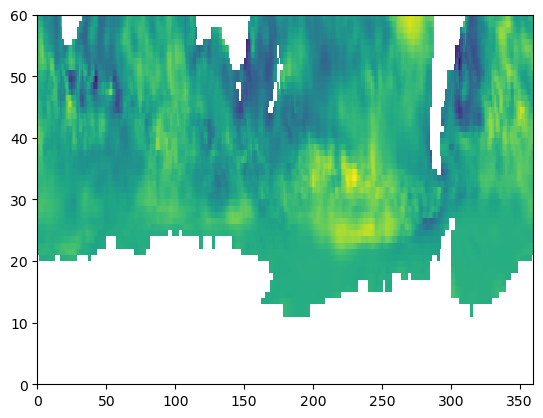

In [87]:
plt.pcolormesh(test.sst_an.isel(reftime=30).mean(dim='r'))

In [88]:
test.close()

In [ ]:
# plan: 
# 1) open mfdataset, extracting 1 block from each file; loop through leadtimes: 1, lat: 90, lon: 90
# 2) save anom and detrended anom to individual files
for ilead in nleads:
    for jj in range(0,180,60):
            fnamout=fnameCanESMAnomByLead(workdir,climyrs[0],climyrs[-1],ilead,jj,ii)
            with xr.open_mfdataset(flist,parallel=True,combine='nested',concat_dim='reftime',
                                   preprocess=lambda ff: ff.isel(leadtime=ilead,lat=slice(jj,jj+90),lon=slice(ii,ii+90)) ) as ff:


ff= xr.open_mfdataset(flist,parallel=True,combine='nested',concat_dim='reftime',
        preprocess=lambda ff: ff.isel(leadtime=ilead,lat=slice(jj,jj+60)),decode_times=False)
sst_an2=ff.sst_an.chunk({'reftime':ff.sst_an.shape[0],'r':20,'lat':20,'lon':360})
# fix time
reftime=[dt.datetime(yy,mm,1,0,0) for yy in range(1993,2025) for mm in range(1,13) if yy<2024 or mm<=6]
time=[dt.datetime(yy,mm,1,0,0)+dt.timedelta(hours=float(ff.leadtime.values)) for yy in range(1993,2025) for mm in range(1,13) if yy<2024 or mm<=6]

fout=xr.Dataset(data_vars={'sst_an':(['reftime','r','lat','lon'],sst_an2.data),
                           'time':(['reftime',],time,{'long_name':'Real Time'})},
                coords={'reftime':reftime,
                        'r':np.arange(0,ff.sst_an.shape[1]),
                        'lat':ff.lat,
                        'lon':ff.lon})
fnamout=fnameCanESMAnomByLead(workdir,climyrs[0],climyrs[-1],ilead,jj)
mkdirs(fnamout)
fout.to_netcdf(fnamout,mode='w') # encoding={'sst_an': {'chunksizes': [Anom0.shape[0],1,20,360]}}
ff.close()

In [15]:
len(flist)

372

In [17]:
2100/215*372/8

454.18604651162786

In [35]:
climyrs=[1993,2023]
firstyear=1993
#for ll in range(0,215):
ll=0
flist=[fnameCanESMAnom(workdir,climyrs[0],climyrs[-1],5*int(ll/5),5*(int(ll/5)+1)-1,mm) for mm in range(1,13)]

In [7]:
test=xr.open_dataset(flist[9],decode_times=False)

In [9]:
test.leadtime.values

array([ 15.,  39.,  63.,  87., 111.])

In [13]:
test.reftime.values/24

array([    0.,   365.,   730.,  1096.,  1461.,  1826.,  2191.,  2557.,
        2922.,  3287.,  3652.,  4018.,  4383.,  4748.,  5113.,  5479.,
        5844.,  6209.,  6574.,  6940.,  7305.,  7670.,  8035.,  8401.,
        8766.,  9131.,  9496.,  9862., 10227., 10592., 10957.])

In [89]:
test.close()

In [90]:
client.close()

In [91]:
cluster.close()

In [ ]:
# rename files:
for ilead in nleads:
    for jj in range(0,180,60):
        old=fnameCanESMAnomByLeadOld(workdir, climyrs[0], climyrs[-1], ilead, jj)
        new=fnameCanESMAnomByLead(workdir, climyrs[0], climyrs[-1], ilead, jj)
        os.rename(old,new)

In [1]:
# detrend

In [6]:
ilead=0
jj=0

In [10]:
fin=fnameCanESMAnomByLead(workdir, climyrs[0], climyrs[-1], ilead, jj)
fout=fnameCanESMAnomDetrByLead(workdir, climyrs[0], climyrs[-1], ilead, jj)

In [11]:
fin

'/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily//byLead/anomByLead_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L000_j000_ocean_1d_surface_tso.nc'

In [12]:
ff= xr.open_dataset(fin,decode_times=False)#parallel=True,

In [33]:
215/5

43.0

In [13]:
mod_val=ff.sst_an
mod_val

<xarray.DataArray 'sst_an' (reftime: 378, r: 20, lat: 60, lon: 360)> Size: 1GB
[163296000 values with dtype=float64]
Coordinates:
  * lat       (lat) float64 480B -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
    leadtime  float64 8B ...
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * reftime   (reftime) int64 3kB 0 31 59 90 120 ... 11382 11413 11443 11474
  * r         (r) int64 160B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

In [26]:
out=lsqfit_md_detr(ff.sst_an)

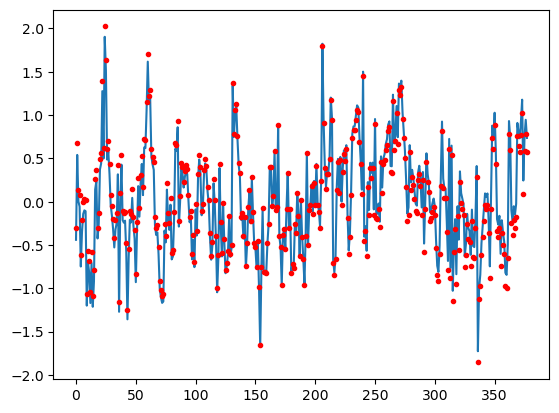

In [27]:
plt.plot(ff.sst_an[:,0,-1,100])
plt.plot(out[:,0,-1,100],'r.')

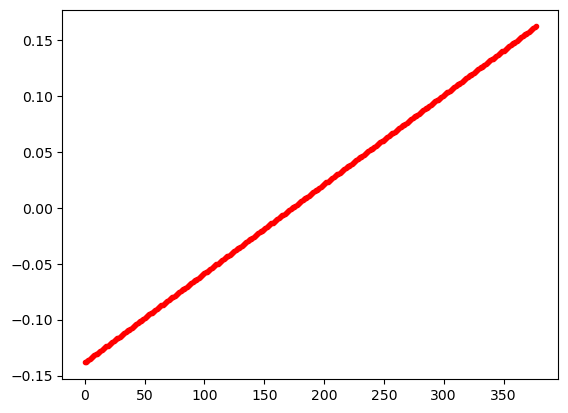

In [28]:
plt.plot(ff.sst_an[:,0,-1,100]-out[:,0,-1,100],'r.')

In [29]:
    data=np.asarray(ff.sst_an)
    dshape = data.shape
    N=dshape[0]
    X=np.concatenate([np.ones((N,1)), np.expand_dims(np.arange(0,N),1)],1)
    #X=np.arange(0,N).reshape((N,1))
    newdata = np.reshape(data,(N, np.prod(dshape, axis=0) // N)).copy() # // is floor division; ensure copy
    b=np.linalg.lstsq(X,newdata,rcond=None)[0] # res=np.sum((np.dot(X,b)-Y)**2)
    ydetr=newdata-np.dot(X,b)
    ydetr=np.reshape(ydetr,dshape)

In [30]:
b=lsqfit_md_basic(X,data)

In [31]:
b

array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [-0.21506719, -0.20188466, -0.19462972, ..., -0.23426313,
          -0.2304625 , -0.22718973],
         [-0.18198568, -0.17008877, -0.16939763, ..., -0.21004097,
          -0.20003213, -0.1977368 ],
         [-0.15526506, -0.14785321, -0.14720297, ..., -0.17646781,
          -0.1724075 , -0.17223362]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [-0.21619752, -0.20236315

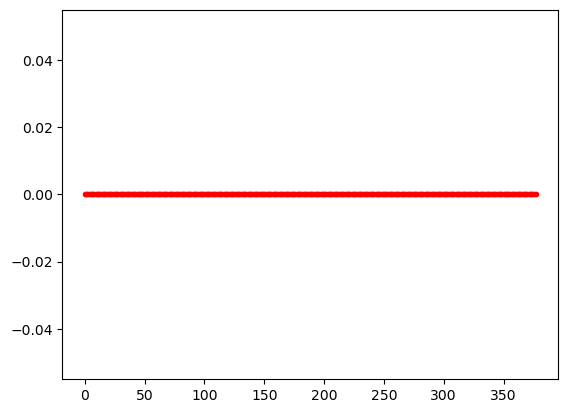

In [32]:
plt.plot(ydetr[:,0,-1,100]-out[:,0,-1,100],'r.')